# K-Means

### 0. Loading packages

For this interactive introduction to K-Means we first need to load packages we will use in these examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy.linalg import norm
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### 1. Initializing data

To test our K-Means algorithm we need data, we will start by creating three distinguished clusters with different standard deviations. Examples will have two features and will belong to one of three clusters. Characteristics like *location of centers* and *number of clusters* will be important for later, because we will need to guess thiese numbers later for our algorithm to work as best as possible. We will use *sklearn*'s [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

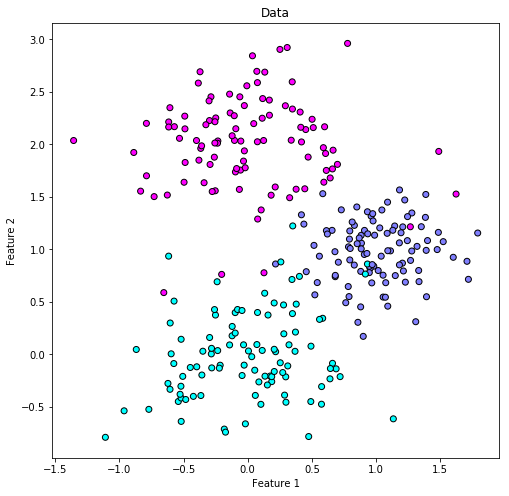

In [2]:
n_samples = 300
n_features = 2
centers = [[0, 0], [1, 1], [0, 2]]
cluster_std = [0.45, 0.3, 0.45]
seed = 96

X, y = make_blobs(n_samples, n_features, centers, cluster_std, random_state=seed)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.get_cmap('cool'), edgecolors='k')
plt.title('Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### 2. Implementing K-Means algorithm

*(TODO: theroetical definition of K-Means algorithm)*

Below is the flowchart of algorithm's training process:
![K-Means iterative process flowchart](img/kmeans-flowchart.png)

Here we will try creating our own K-Means algorithm and implement it as *DIYKMeans* class. *(TODO: definitions and mathematical expressions for $b$, $J$, calculating new centroids, etc.)*

In [3]:
class DIYKMeans:
    def __init__(self, init_centroids, num_clusters=3, max_iter=300, tol=10e-3):
        if init_centroids is None or init_centroids.shape[0] != num_clusters:
            raise Exception("Exactly `num_clusters` of initial centroids must be provided.")
        
        self.num_clusters = num_clusters
        self.centroids = deepcopy(init_centroids)
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, X):
        prev_J = 0
        for i in range(1, self.max_iter + 1):
            b = self.predict(X)
            self.centroids = np.array([np.sum(X[b == k], axis=0) / np.sum(b == k) for k in range(self.num_clusters)])
            
            J = np.sum(norm(X - self.centroids[b])**2)
            
            if (abs(J - prev_J) < self.tol):
                break
            
            prev_J = J
            
        return self.centroids
        
    def predict(self, X):
        return np.argmin([[norm(dot - centroid) for centroid in self.centroids] for dot in X], axis=1)

### 3. Testing the algorithm
Now we will test our implementation on data we created above. After running, iterative updates of centroids will look something like this:
![K-Means iterative process visualized](img/kmeans-visualized.gif)

Centroids:
[[-0.05574492  2.07584403]
 [ 0.98795728  1.0028869 ]
 [-0.04080576 -0.043764  ]]


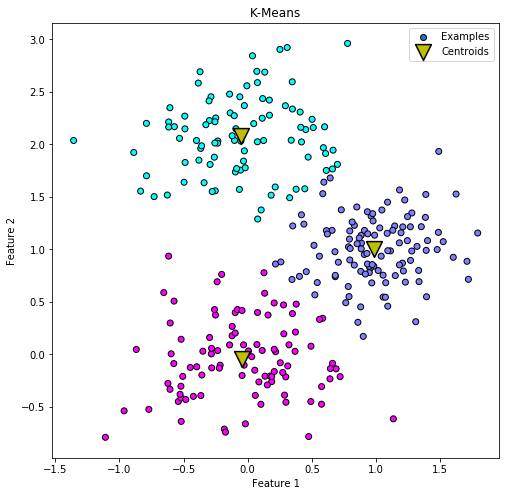

In [49]:
init_centroids = np.array([[10e-3, 10e-3], [10e-3, -10e-3], [-10e-3, -10e-3]])
model = DIYKMeans(init_centroids)
centroids = model.fit(X)

print('Centroids:')
print(centroids)

plt.figure(figsize=(8, 8))
# todo: plot so that examples that are classified incorrectly appear as squares
plt.scatter(X[:,0], X[:,1], c=model.predict(X), edgecolors='k',
            cmap=plt.get_cmap('cool'), label='Examples')
plt.scatter(centroids[:,0], centroids[:,1], s=250, c='y', marker='v',
            edgecolors='k', linewidths=1.5, label='Centroids')
plt.title('K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

We can see the centroids we got after training the model match almost perfectly to the centers we used to create the data.

### 4. How to determine the value of hyperparameter $K$

Last example worked well, because we already new how many clusters we had to approximate. With real data, we usually won't know how many centroids to use. Hyperparameter $K$ determines the number of centroids K-Means algorithm will train, hyperparameter meaning it must be defined when creating the model and can't be changed afterwards.

One method to determine &K& is called __*[`elbow method`](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)*__. *(TODO: theretical definition of elbow method*)

Below, we will switch to already implemented K-Means algorithm available in [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). We'll train the model for $K$s in range from $[0,1,\ldots,15]$. Plotting error $J$ for every $K$ will enable us to determine which $K$ improves $J$ the most. This value of $K$ is the one that we want to pick.

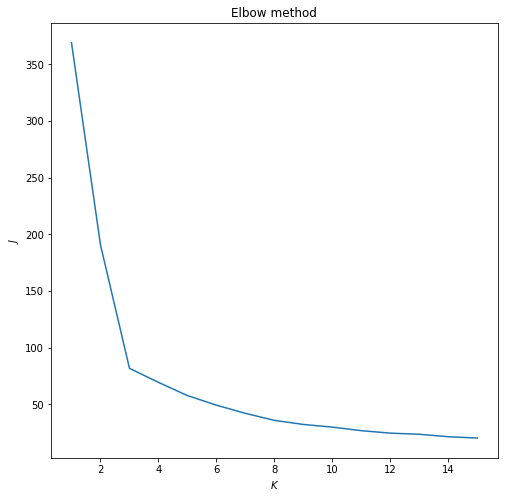

In [5]:
Ks = range(1, 16)
Js = []

for K in Ks:
    model = KMeans(K)
    model.fit(X)
    Js.append(-model.score(X))

plt.figure(figsize=(8, 8))
plt.plot(Ks, Js)
plt.title('Elbow method')
plt.xlabel('$K$')
plt.ylabel('$J$')
plt.show()

We can clearly see that the steepest slope is just before the point where $K = 3$, which matches perfectly since our data is made of three clusters.

### 5. Evaluating the algorithm

To evaluate performance of K-Means algorithm we often used metric called __*[`Rand index`](https://davetang.org/muse/2017/09/21/the-rand-index/)*__. *(TODO: theoretical definition of Rand index*)

*(TODO: mathematical expressions for $a$, $b$, $c$, etc.)*

In [6]:
def rand_index_score(y_gold, y_predict):
    a = 0
    b = 0
    c = 0
    d = 0
    
    for i in range(y_gold.shape[0]):
        for j in range(i + 1, y_gold.shape[0]):
            same_a = y_gold[i] == y_gold[j]
            same_b = y_predict[i] == y_predict[j]

            a += same_a and same_b
            b += not same_a and not same_b
            c += same_a and not same_b
            d += not same_a and same_b
            
    rand_index = 1. * (a + b) / (a + b + c + d)
    return rand_index

Now, we can evaluate performance K-Means on our data and compare our implementation of *Rand index* with *sklearn*'s [`metrics.adjusted_rand_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html). *(TODO: explain difference between adjusted and non adjusted Rand index?)*

In [7]:
model = KMeans(n_clusters=3)
model.fit(X)

print('Rand index:\t\t{:.4f}'.format(rand_index_score(y, model.predict(X))))
print('Adjusted Rand index:\t{:.4f}'.format(adjusted_rand_score(y, model.predict(X))))

Rand index:		0.9392
Adjusted Rand index:	0.8630


### 6. Assumtions of K-Means

Just like most Machine learning models, K-Means won't fit all use-cases. K-Means has three assumtions and if any of them is violated, the algorithm will fail. There is just [`no free lunch...`](http://www.no-free-lunch.org/)

In [8]:
# todo: find better data to demonstrate examples, tidy the plots below and write explanations for each case

##### 6.1. All clusters have the same variance

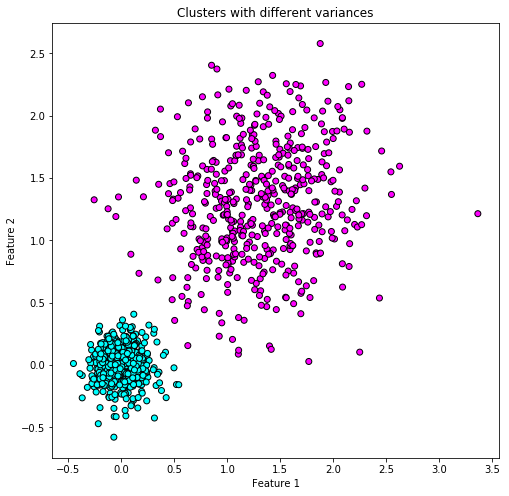

In [43]:
X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)

plt.figure(figsize=(8, 8))
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), edgecolor='k')
plt.title('Clusters with different variances')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

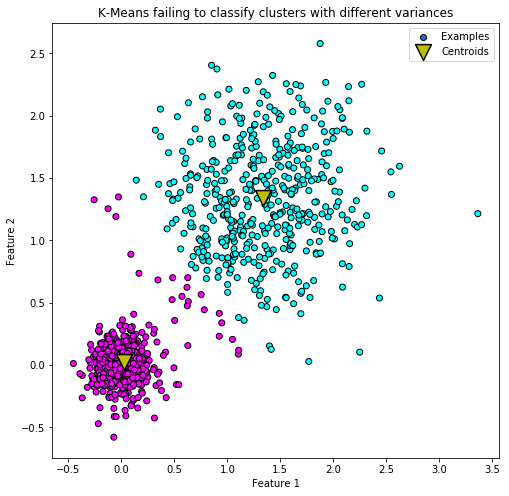

In [52]:
model = KMeans(n_clusters=2)
model.fit(X1)

plt.figure(figsize=(8, 8))
plt.scatter(X1[:,0], X1[:,1], c=model.predict(X1),
            cmap=plt.get_cmap("cool"), edgecolor='k', label='Examples')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=250,
            c='y', marker='v', edgecolors='k', linewidths=1.5, label='Centroids')
plt.title('K-Means failing to classify clusters with different variances')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

##### 6.2. Distribution variance of each cluster is spherical

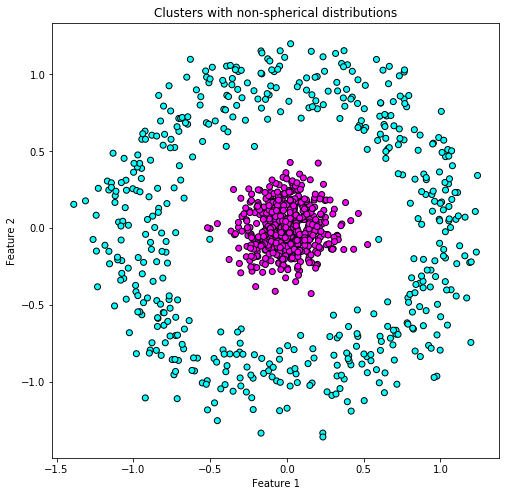

In [45]:
X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)

plt.figure(figsize=(8, 8))
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), edgecolor='k')
plt.title('Clusters with non-spherical distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

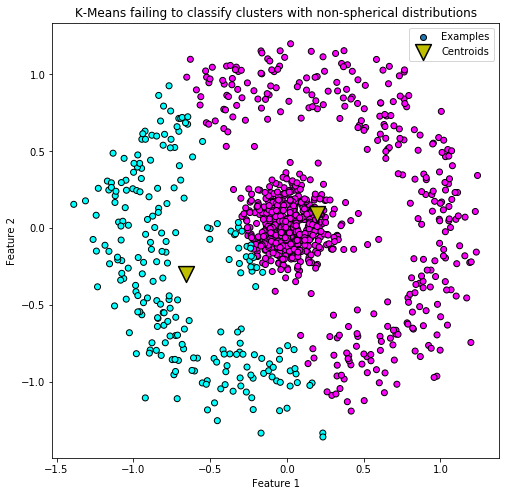

In [53]:
model = KMeans(n_clusters=2)
model.fit(X2)

plt.figure(figsize=(8, 8))
plt.scatter(X2[:,0], X2[:,1], c=model.predict(X2),
            cmap=plt.get_cmap("cool"), edgecolor='k', label='Examples')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=250,
            c='y', marker='v', edgecolors='k', linewidths=1.5, label='Centroids')
plt.title('K-Means failing to classify clusters with non-spherical distributions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

##### 6.2. Prior probabilities for all $K$ clusters are the same, meaning each cluster has roughly equal number of examples

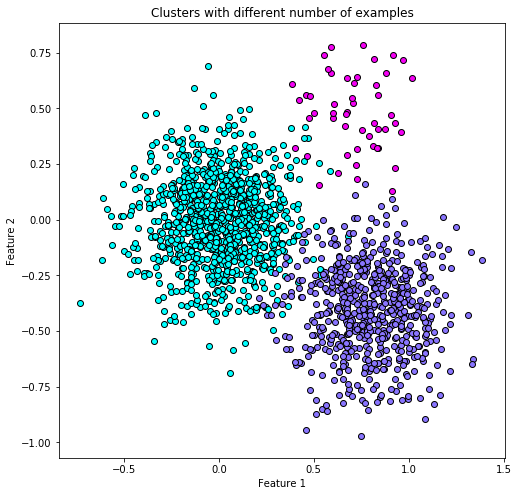

In [55]:
plt.figure(figsize=(8, 8))

X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", edgecolor='k')
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", edgecolor='k')
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", edgecolor='k')

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

plt.title('Clusters with different number of examples')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

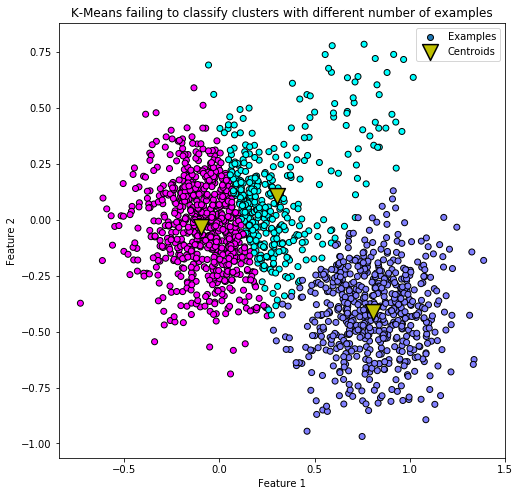

In [54]:
model = KMeans(n_clusters=3)
model.fit(X3)

plt.figure(figsize=(8, 8))
plt.scatter(X3[:,0], X3[:,1], c=model.predict(X3),
            cmap=plt.get_cmap("cool"), edgecolor='k', label='Examples')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=250,
            c='y', marker='v', edgecolors='k', linewidths=1.5, label='Centroids')
plt.title('K-Means failing to classify clusters with different number of examples')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### 7. *(TODO: talk about [`GMM`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and show how it improves on K-Means?)*